# 1. CartPole problem in OpenAI gym

This notebook demonstrates using reinforcement learning for the Cart-Pole problem comes from OpenAI gym (https://gym.openai.com/envs/CartPole-v0/). The OpenAI gym can be installed by

$ pip3 install --upgrade gym

# 1.1 Setup

In [1]:
#Common imports
import numpy as np
import os
import sys

# To set a specific random seed
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To make plots and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# set the directory for export figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Import OpenAI gym
import gym


# 1.2 The Cart-Pole environment
In the CartPole environment, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [2]:
env=gym.make("CartPole-v0")
obs=env.reset()
obs
#the observation is a 1D array containing four elements: horizontal position, velocity, velocity, and the abgle of the pole

array([ 0.03063828, -0.03797335, -0.02488233,  0.00482268])

<IPython.core.display.Javascript object>


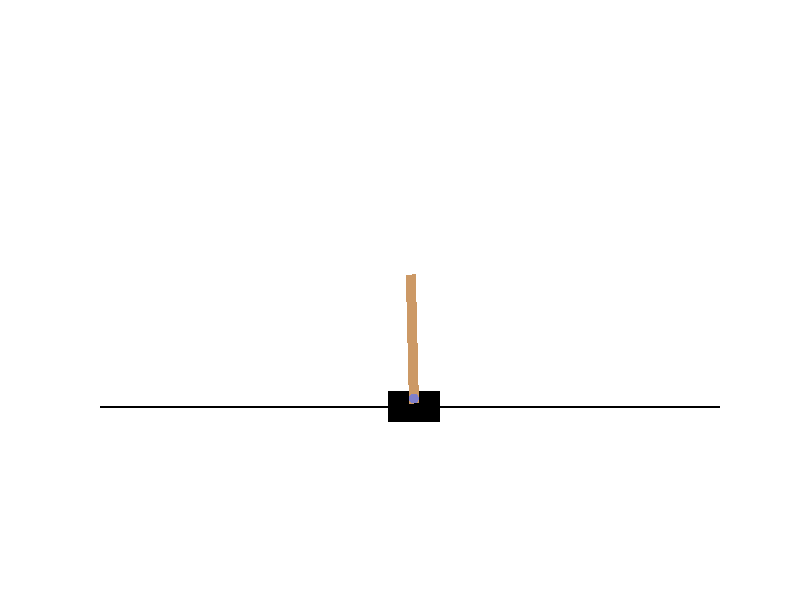

In [3]:
def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

plot_cart_pole(env, obs)

In [4]:
env.action_space

Discrete(2)

In [5]:
action=1 #accelerate right
obs,reward, done, infor =env.step(action)
obs

array([ 0.02987882,  0.15749645, -0.02478588, -0.2956059 ])

In [6]:
reward

1.0

In [7]:
done

False

## 1.3 A simple hard core policy

We first demonstrate a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right:

<IPython.core.display.Javascript object>


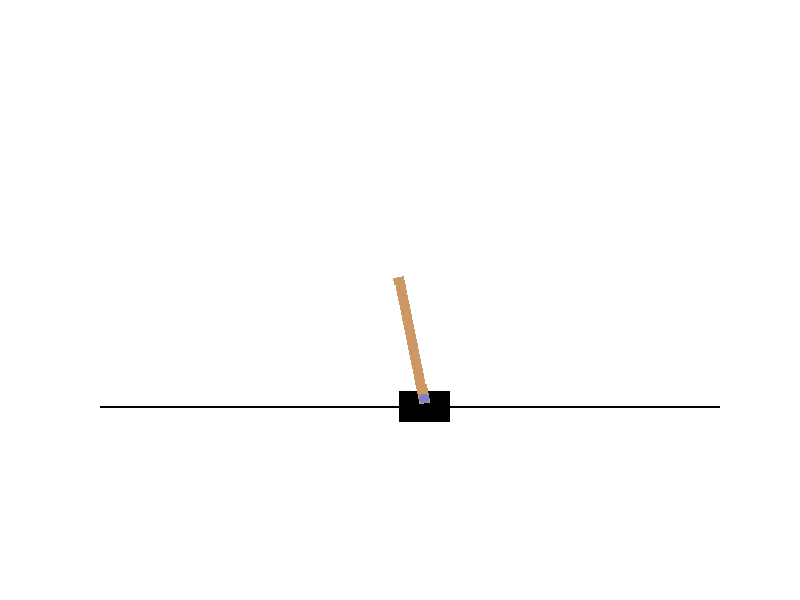

In [8]:
def basic_policy(obs):
    # a basic policy 
    angle=obs[2]
    return 0 if angle<0 else 1

frames=[]
n_max_steps= 1000

obs = env.reset()

for step in range(n_max_steps):
    img=env.render(mode="rgb_array")
    frames.append(img)
    action=basic_policy(obs)
    obs,reward,done,info=env.step(action)
    if done:
        break

        
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)
video=plot_animation(frames)
plt.show()

We can see that the system is unstable and the pole ended up too tilted after just a few steps. So we need a smarter policy.

## 1.4 Neural Network Policies
We now build a neural network that will take the observations as inputs, and outputs the action to take for each observation. The output is a probability distribution over all actions. For the Cart-Pole environment, the neural networr output a probability p of the action 0 (left), and the probability for the action 1 (right) is therefor 1-p.

We use Tensorflow to build and train the neural network.

In [9]:
import tensorflow as tf

# 1. Specify the network architecture

n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 # 4 hidden layes for this simple problem
n_outputs = 1 # output the probability p of the action 0
learning_rate = 0.01
initializer = tf.variance_scaling_initializer()

# 2. Build the NN

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation = tf.nn.elu,
                         kernel_initializer = initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis =1, values = [outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples = 1)



/workspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1.5 Policy Gradient
To train this neural network we will need to define the target probabilities y. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. The Policy Gradients algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely.

In [10]:
y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape = grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf. global_variables_initializer()
saver = tf.train.Saver()

In [11]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

Now we have all we need to train the neural network:

In [12]:
env = gym.make("CartPole-v0")

n_games_per_update = 10 # train the policy every 10 episodes
n_max_steps = 1000 # max steps per episode 
n_iterations = 250 # number of training iterations
save_iterations = 10 # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

Now we trained the neural network model and the following movie shows that the neural network has successfully learnt to balance the pole on the cart!

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


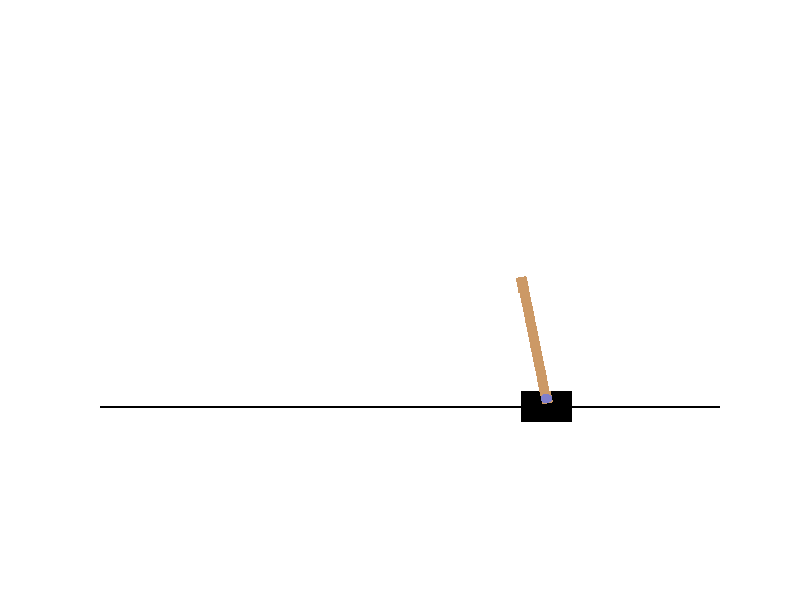

In [13]:
env.close()

def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v1")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

# 2. Markov Decision Process

In [14]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) ... Total rewards = 280
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 210
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 50
States (+rewards): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 ... Total rewards = 370
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 270
Summary: mean=123.0, std=130.984121, min=-280, max=480

policy_random
States (+rewards): 0 0 (10) 0 (10) 0 0 (10) 0 (10) 0 0 (10) 0 (10) 0 ... Total rewards = -40
States (+rewards): 0 1 1 (-50) 2 (40) 0 0 0 0 0 0 ... Total rewards = 100
States (+rewards): 0 0 0 0 1 1 1 1 1 1 (-50) ... Total rewards = -50
States (+rewards): 0 0 0 0 1 1 (-50) 2 (40) 0 0 0 ... Total rewards = 110
States (+rewards): 0 1 (-50) 2 (40) 0 0 0 0 0 0 0 ... Total rewards = -10

## 2.1 Q-Value Iteration

$Q_{k+1}(s,a) \leftarrow \sum_{s'} T(s,a,s') \left[R(s,a,s')+\gamma \cdot \max_{a'} Q_k (s', a')\right]$

In [15]:
nan = np.nan

T = np.array([
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
    ])

R = np.array([
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [nan, nan, nan], [0, 0, -50]],
        [[nan, nan, nan], [+40, 0, 0], [nan, nan, nan]],
    ])

possible_actions = [[0, 1, 2], [0, 2], [1]]

Q = np.full((3,3), -np.inf)

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 
    
learning_rate = 0.01
discount_rate = 0.95
n_iterations = 100
    
for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s,a] = np.sum(
            [T[s,a,sp]*(R[s,a,sp]+discount_rate*np.max(Q_prev[sp]))
            for sp in range(3)])

In [16]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [17]:
np.argmax(Q, axis = 1)

array([0, 2, 1])

## 2.2 Temporal Difference Learning and Q-Learning

TD Learning algorithm:

$V_{k+1}(s) \leftarrow (1-\alpha) V_k(s) +\alpha(r+\gamma \cdot V_k(s'))$

Q-Learning algorithm:

$Q_{k+a}(s,a) \leftarrow (1-\alpha) Q_k (s,a) +\alpha\left( r+\gamma \cdot \max_{a'} Q_k (s', a')\right)$

Here is an implementation of Q-Learning:

In [18]:
import numpy.random as rnd

learning_rate0 = 0.05
learning_rate_decay =0.1 
n_iterations = 20000

s = 0 # initial state

Q= np.full((3,3), -np.inf)

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0
    
for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s]) # choose an action randomly
    sp = rnd.choice(range(3), p = T[s,a]) # pick next state using T[s,a]
    reward = R[s,a,sp]
    learning_rate = learning_rate0/(1+iteration*learning_rate_decay)
    Q[s, a] =learning_rate * Q[s,a]+(1-learning_rate)*(reward+discount_rate*np.max(Q[sp]))
    s=sp

In [19]:
Q

array([[114.27782198, 108.56382378,  87.66504324],
       [ 87.6645209 ,         -inf,  92.27844307],
       [        -inf, 149.76678218,         -inf]])

# 3. Learn to Play MsPacman Using Deep Q-Learning
Maximize your score in the Atari 2600 game MsPacman. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3) Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from {2,3,4}.

## 3.1 Creating the MsPacman environment

In [20]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [21]:
env.action_space

Discrete(9)

## 3.2 Preprocessing
Preprocessing the images will greatly speed up traing

<IPython.core.display.Javascript object>


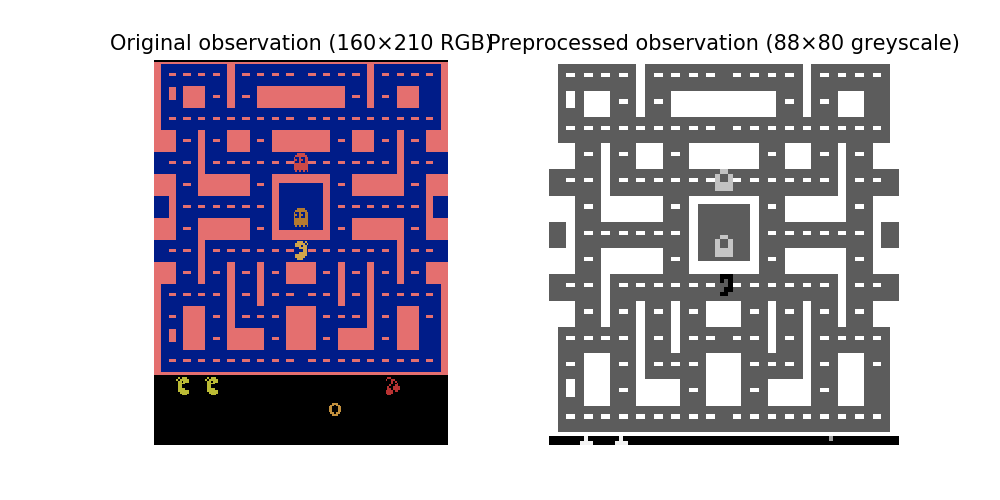

In [22]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
#save_fig("preprocessing_plot")
plt.show()

## 3.3 Build DQN

In [23]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)



In [24]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [25]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [27]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [28]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)


In [29]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [30]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [31]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [ ]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
Iteration 497252	Training step 210814/4000000 (5.3)%	Loss 1.635323	Mean Max-Q 6.837358    